In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from loss_function import CombinedLoss
from train_test import train_model
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets
from visualization import plot_mean_power_spectrum
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders
from qualitative_eval import mse, r2_score, pearson_corr

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


# Data Pre-processing

In [3]:
ds_HR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 
ds_LR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_LR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 

In [10]:
# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

In [5]:
# Parameters
num_snapshots = 100
sigma = 0.2
amplitude = 1.0
var = "u_relative"  # replace with your variable name if different

# Get spatial shape, dims, and coords from the reference dataset
template = ds_LR_reg[var]
dims = template.dims
coords = template.coords
H, W = template.shape[-2], template.shape[-1]

# Create coordinate arrays for the blob
y = np.linspace(-1, 1, H)
x = np.linspace(-1, 1, W)
X, Y = np.meshgrid(x, y)

# Generate 100 blobs
blobs = []
for _ in range(num_snapshots):
    x0 = np.random.uniform(-0.5, 0.5)
    y0 = np.random.uniform(-0.5, 0.5)
    blob = amplitude * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))
    blobs.append(blob)

# Stack into a 3D array
blob_array = np.stack(blobs, axis=0)

# Expand to match full dims of template, assuming time is first dim
# If your dataset uses another name for time, adjust accordingly
full_dims = (dims[0], dims[1], dims[2])  # e.g., ('time', 'yt_ocean', 'xt_ocean')
new_coords = {
    dims[0]: coords[dims[0]][:num_snapshots],
    dims[1]: coords[dims[1]],
    dims[2]: coords[dims[2]]
}

# Create new DataArray
blob_da = xr.DataArray(blob_array, dims=full_dims, coords=new_coords)

# Wrap into a Dataset under the specified variable name
blob_ds = xr.Dataset({var: blob_da})

In [11]:
ds_LR_blob = blob_ds
ds_HR_blob = blob_ds * 0.1

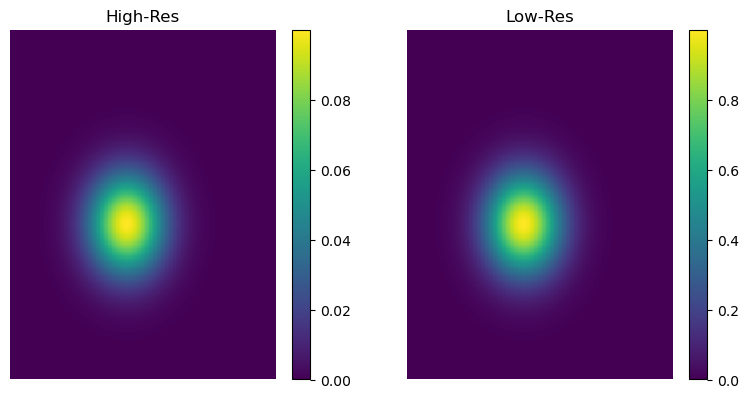

In [13]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted figure size

# Plot the high-resolution data
im1 = axes[0].pcolor(ds_HR_blob.u_relative.isel(time=0))
axes[0].set_title("High-Res")
axes[0].axis('off')  # Turn off the axes
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot the low-resolution data
im2 = axes[1].pcolor(ds_LR_blob.u_relative.isel(time=0))
axes[1].set_title("Low-Res")
axes[1].axis('off')  # Turn off the axes
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Add space between subplots
plt.subplots_adjust(wspace=20)  # Increase space between plots

# Adjust layout to center the plots
plt.tight_layout()

# Show the plot
plt.show()

# Case 1: Standardization

In [14]:
train_loader, val_loader, test_loader, HR_test, LR_test = prepare_dataloaders(ds_HR_blob, ds_LR_blob, var='u_relative', batch_size=32, normalization_type='standardization')

Training set size: 70
Validation set size: 15
Testing set size: 15


In [15]:
# Set the values you want
in_channels = 1  # num of input channels
image_height = LR_test.shape[1]
image_width = LR_test.shape[2]
output_channels = 1 

# Instantiate the model with the parameters
model = CNN(in_channels, image_height, image_width, output_channels)
model

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=59200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=60000, bias=True)
)

In [17]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_stand_dummy.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 15341024
Resuming from epoch 9 with best val losses []
Epoch 10, Train Loss: 7.172e-01, Val Loss: 6.935e-01, Epoch Time: 23.43s
Model saved at epoch 10
Epoch 11, Train Loss: 6.471e-01, Val Loss: 6.307e-01, Epoch Time: 22.37s
Model saved at epoch 11
Epoch 12, Train Loss: 5.822e-01, Val Loss: 5.680e-01, Epoch Time: 23.28s
Model saved at epoch 12
Epoch 13, Train Loss: 5.197e-01, Val Loss: 5.092e-01, Epoch Time: 22.43s
Model saved at epoch 13
Epoch 14, Train Loss: 4.657e-01, Val Loss: 4.547e-01, Epoch Time: 20.40s
Model saved at epoch 14
Epoch 15, Train Loss: 4.162e-01, Val Loss: 4.134e-01, Epoch Time: 20.84s
Model saved at epoch 15
Epoch 16, Train Loss: 3.744e-01, Val Loss: 3.743e-01, Epoch Time: 19.98s
Model saved at epoch 16
Epoch 17, Train Loss: 3.417e-01, Val Loss: 3.378e-01, Epoch Time: 16.77s
Model saved at epoch 17
Epoch 18, Train Loss: 3.092e-01, Val Loss: 3.044e-01, Epoch Time: 27.41s
Model saved at epoch 18
Epoch 19, Train Loss: 2.818e-01, Val Loss: 2.771e-

In [18]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_stand_dummy.pth')
sr_pred

Loaded model parameters from ./model_CNN_stand_dummy.pth


<xarray.DataArray (time: 15, yt_ocean: 300, xt_ocean: 200)> Size: 4MB
array([[[-0.27056438, -0.24626917, -0.393625  , ..., -0.43210113,
         -0.34013385, -0.30449614],
        [-0.32837993, -0.26668167, -0.33693737, ..., -0.29610497,
         -0.3557975 , -0.37730452],
        [-0.47488177, -0.41564447, -0.30762047, ..., -0.4602831 ,
         -0.4169451 , -0.25281158],
        ...,
        [-0.38635784, -0.28517914, -0.22760531, ..., -0.38462913,
         -0.4194582 , -0.3417668 ],
        [-0.31831524, -0.3574425 , -0.35521898, ..., -0.35604638,
         -0.3018675 , -0.3271168 ],
        [-0.32923526, -0.34663248, -0.3779448 , ..., -0.3528819 ,
         -0.33043256, -0.3640147 ]],

       [[-0.3618026 , -0.32747793, -0.47926185, ..., -0.37319666,
         -0.34895226, -0.34733427],
        [-0.42928594, -0.38521227, -0.40655684, ..., -0.5161527 ,
         -0.24009535, -0.35866544],
        [-0.3855862 , -0.40580478, -0.3767196 , ..., -0.32586604,
         -0.3870023 , -0.31241253],
...
        [-0.5230877 , -0.59405047, -0.24376321, ..., -0.47967976,
         -0.31727856, -0.40133697],
        [-0.19256341, -0.37452447, -0.25043523, ..., -0.53739995,
         -0.5347148 , -0.40667036],
        [-0.3958118 , -0.47485986, -0.4391192 , ..., -0.35798553,
         -0.6627395 , -0.36976764]],

       [[-0.48125058, -0.51239073, -0.40814498, ..., -0.1108939 ,
         -0.20115393, -0.25237396],
        [-0.2579769 , -0.53225857, -0.41128135, ..., -0.3314253 ,
         -0.21830711, -0.3030345 ],
        [-0.3653956 , -0.20273882, -0.40810865, ..., -0.28405777,
         -0.4195401 , -0.36159822],
        ...,
        [-0.13314249, -0.41675007, -0.39938417, ..., -0.50204283,
         -0.353001  , -0.20297869],
        [-0.17497729, -0.04644502, -0.25789705, ..., -0.42452544,
         -0.39825863, -0.06663543],
        [-0.37096453, -0.40319237, -0.04536898, ..., -0.1500363 ,
         -0.35589412, -0.3288592 ]]], shape=(15, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 120B 0181-04-11 12:00:00 ... 0183-04-11 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

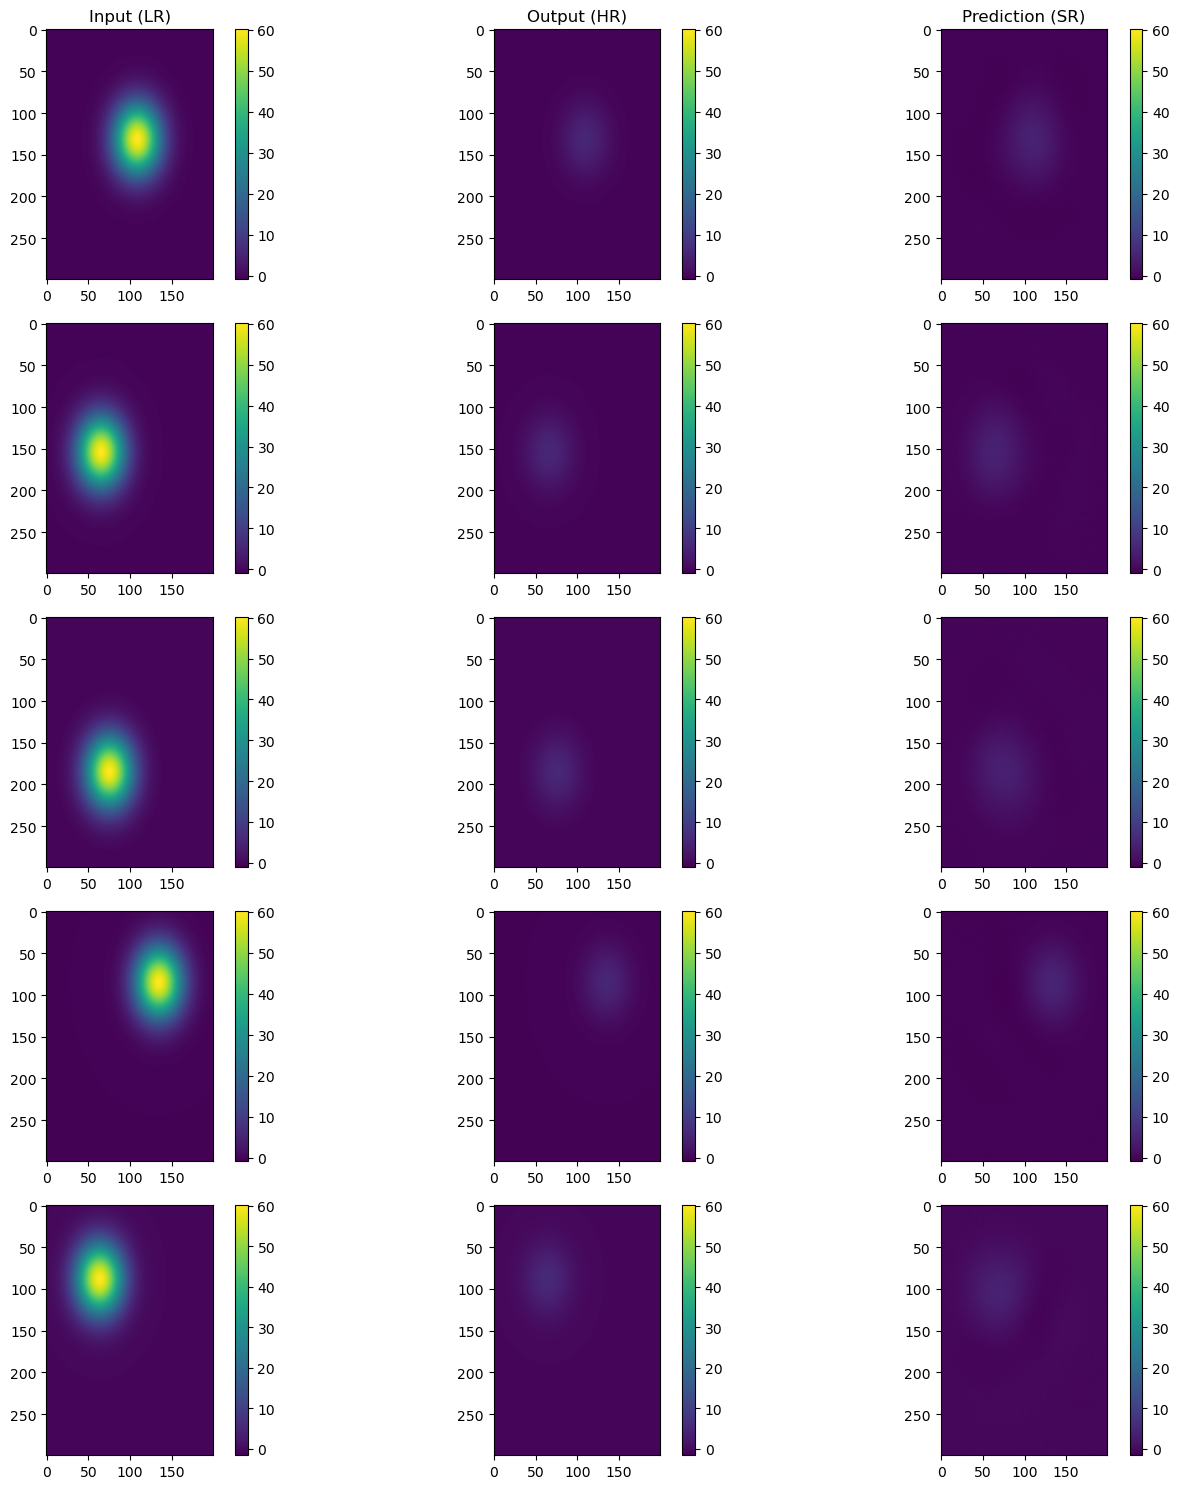

In [19]:
plot_predictions_vs_targets(LR_test, HR_test, sr_pred, num_samples=5, cmap='viridis')

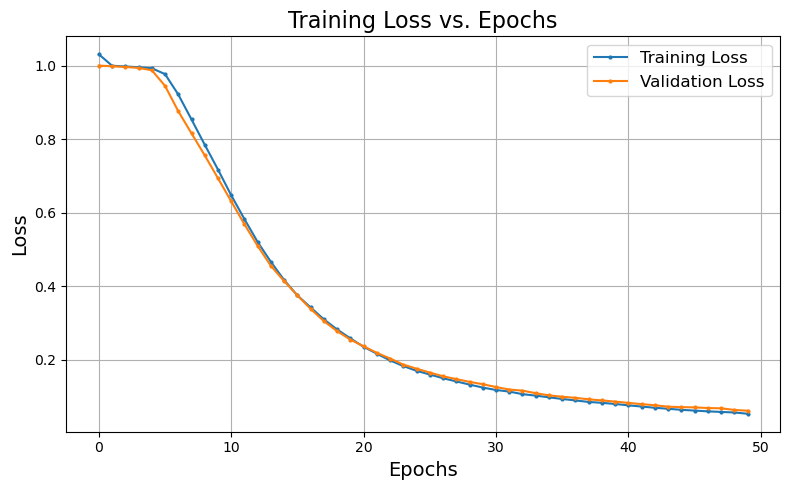

In [20]:
plot_train_val_losses(train_losses, val_losses)

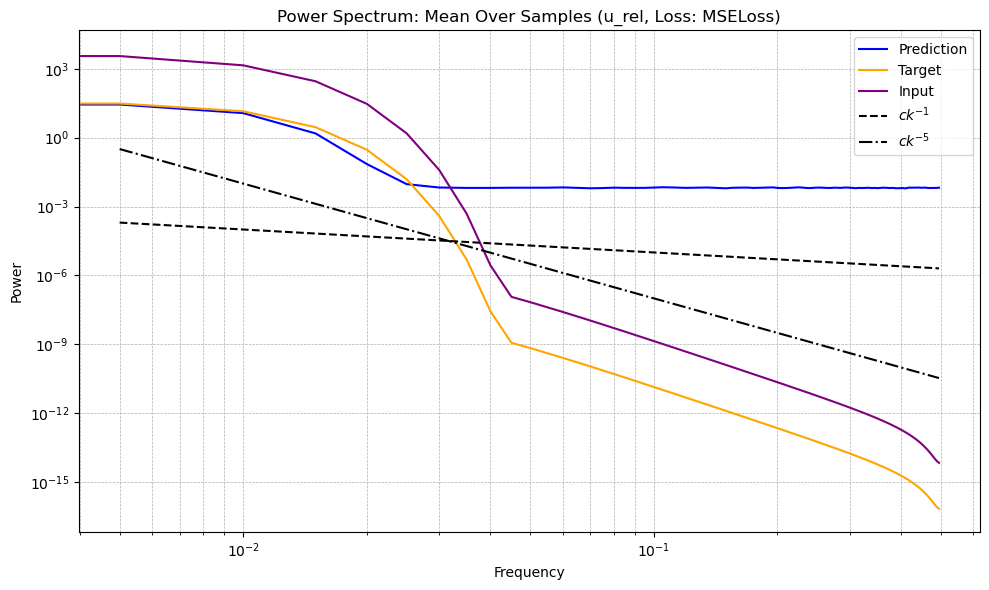

In [21]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6),
    c1=10**-6, c5=10**-12, show_slopes=True)

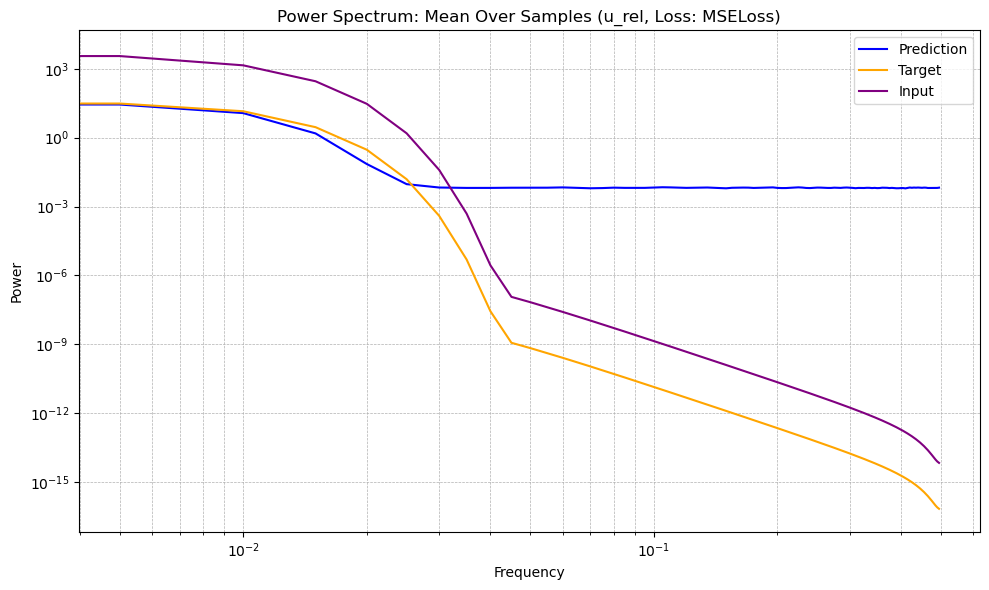

In [22]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6))

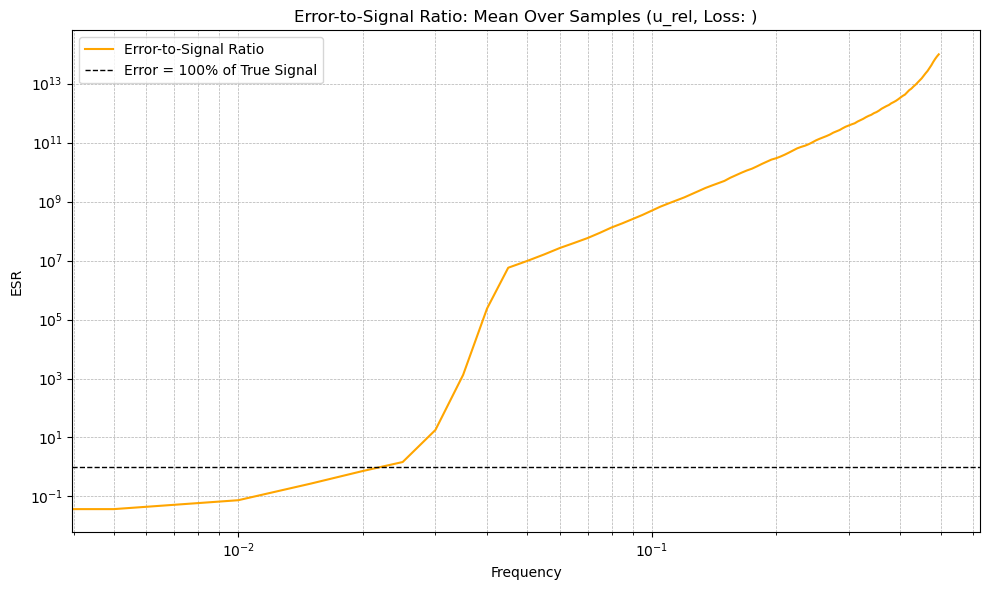

In [23]:
plot_mean_esr(sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="", alpha_label="", figsize=(10, 6))

In [24]:
mse(HR_test, sr_pred)

0.07156851081191681

In [25]:
pearson_corr(HR_test, sr_pred)

0.9637188758578328

In [26]:
r2_score(HR_test, sr_pred)

0.9284256442307701

# Case 2: Normalization

In [27]:
train_loader, val_loader, test_loader, HR_test, LR_test = prepare_dataloaders(ds_HR_blob, ds_LR_blob, var='u_relative', batch_size=32, normalization_type='normalization')

Training set size: 70
Validation set size: 15
Testing set size: 15


In [28]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_norm_dummy.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 15341024
Epoch 1, Train Loss: 6.754e-03, Val Loss: 2.949e-03, Epoch Time: 25.97s
Model saved at epoch 1
Epoch 2, Train Loss: 2.904e-03, Val Loss: 2.491e-03, Epoch Time: 15.76s
Model saved at epoch 2
Epoch 3, Train Loss: 2.674e-03, Val Loss: 2.324e-03, Epoch Time: 36.96s
Model saved at epoch 3
Epoch 6, Train Loss: 1.862e-03, Val Loss: 1.953e-03, Epoch Time: 24.46s
Model saved at epoch 6
Epoch 7, Train Loss: 1.706e-03, Val Loss: 1.883e-03, Epoch Time: 31.14s
Model saved at epoch 7
Epoch 8, Train Loss: 1.609e-03, Val Loss: 1.814e-03, Epoch Time: 34.30s
Model saved at epoch 8
Epoch 9, Train Loss: 1.509e-03, Val Loss: 1.735e-03, Epoch Time: 25.07s
Model saved at epoch 9
Epoch 10, Train Loss: 1.421e-03, Val Loss: 1.677e-03, Epoch Time: 23.74s
Model saved at epoch 10
Epoch 11, Train Loss: 1.326e-03, Val Loss: 1.607e-03, Epoch Time: 23.32s
Model saved at epoch 11
Epoch 12, Train Loss: 1.259e-03, Val Loss: 1.549e-03, Epoch Time: 24.31s
Model saved at epoch 12
Epoch 13, Tra

In [29]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_norm_dummy.pth')
sr_pred

Loaded model parameters from ./model_CNN_norm_dummy.pth


<xarray.DataArray (time: 15, yt_ocean: 300, xt_ocean: 200)> Size: 4MB
array([[[ 1.69135630e-03, -2.13994086e-03,  2.39012763e-03, ...,
          2.90339161e-03, -8.84077698e-03, -5.14088944e-03],
        [ 1.51469186e-03,  1.25960261e-02,  3.71728092e-03, ...,
         -1.00564547e-02,  4.53420728e-03,  1.03398673e-02],
        [ 1.21373348e-02, -1.04540419e-02, -3.47778201e-04, ...,
         -8.28507170e-03, -1.15692588e-02,  4.13407013e-03],
        ...,
        [-8.10999051e-03, -1.41632846e-02, -9.62895155e-03, ...,
          1.04336254e-03, -1.00651849e-02,  5.65780699e-03],
        [-4.88799997e-05,  4.03007586e-03,  9.37644392e-04, ...,
          2.61703879e-03,  4.36161458e-03, -8.26239586e-04],
        [-1.36576621e-02,  2.23887712e-03,  5.87682985e-03, ...,
          9.14545357e-03, -9.57939588e-03,  1.41507760e-02]],

       [[ 1.62628070e-02,  2.99472734e-03, -1.92945562e-02, ...,
          1.01641472e-03, -1.89753138e-02,  1.09543949e-02],
        [-2.52080113e-02,  2.52671912e-03,  8.55457038e-04, ...,
         -1.26908645e-02,  6.53352588e-03,  4.81565669e-03],
        [ 2.03857310e-02,  7.51218200e-03,  1.28639117e-03, ...,
          1.20672956e-02, -1.14033716e-02, -6.17280602e-04],
...
         -2.28737760e-02, -1.76394545e-02, -4.49641608e-03],
        [-2.52001453e-02,  9.61549859e-03, -1.31653594e-02, ...,
         -2.13136785e-02, -1.00583686e-02,  5.05634025e-03],
        [ 9.71133448e-03, -3.41691971e-02,  1.55917723e-02, ...,
         -1.29361376e-02,  1.62811950e-02,  1.01277344e-02]],

       [[ 7.82171637e-03, -7.14684650e-03,  4.03291360e-03, ...,
         -1.60135701e-03,  1.62506700e-02,  8.16972554e-03],
        [-6.11331314e-03,  4.15478833e-03, -8.92820209e-03, ...,
         -9.83330887e-04,  1.79627016e-02,  7.77453929e-03],
        [-8.23461637e-03,  1.36305094e-02,  1.92749761e-02, ...,
          1.49623826e-02,  1.30274333e-02,  1.01825744e-02],
        ...,
        [ 1.97434425e-03,  2.24752352e-02,  1.30595639e-03, ...,
          2.52508000e-03, -1.70800816e-02, -8.83959234e-04],
        [-1.33364275e-02, -1.08673144e-03, -6.33682031e-03, ...,
          5.44965267e-03,  1.84608763e-03, -3.71671468e-03],
        [ 1.16858259e-03, -8.24179500e-04, -6.30561262e-04, ...,
         -9.31341946e-03,  3.62148136e-03, -1.34938210e-03]]],
      shape=(15, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 120B 0183-05-31 12:00:00 ... 0182-09-13 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

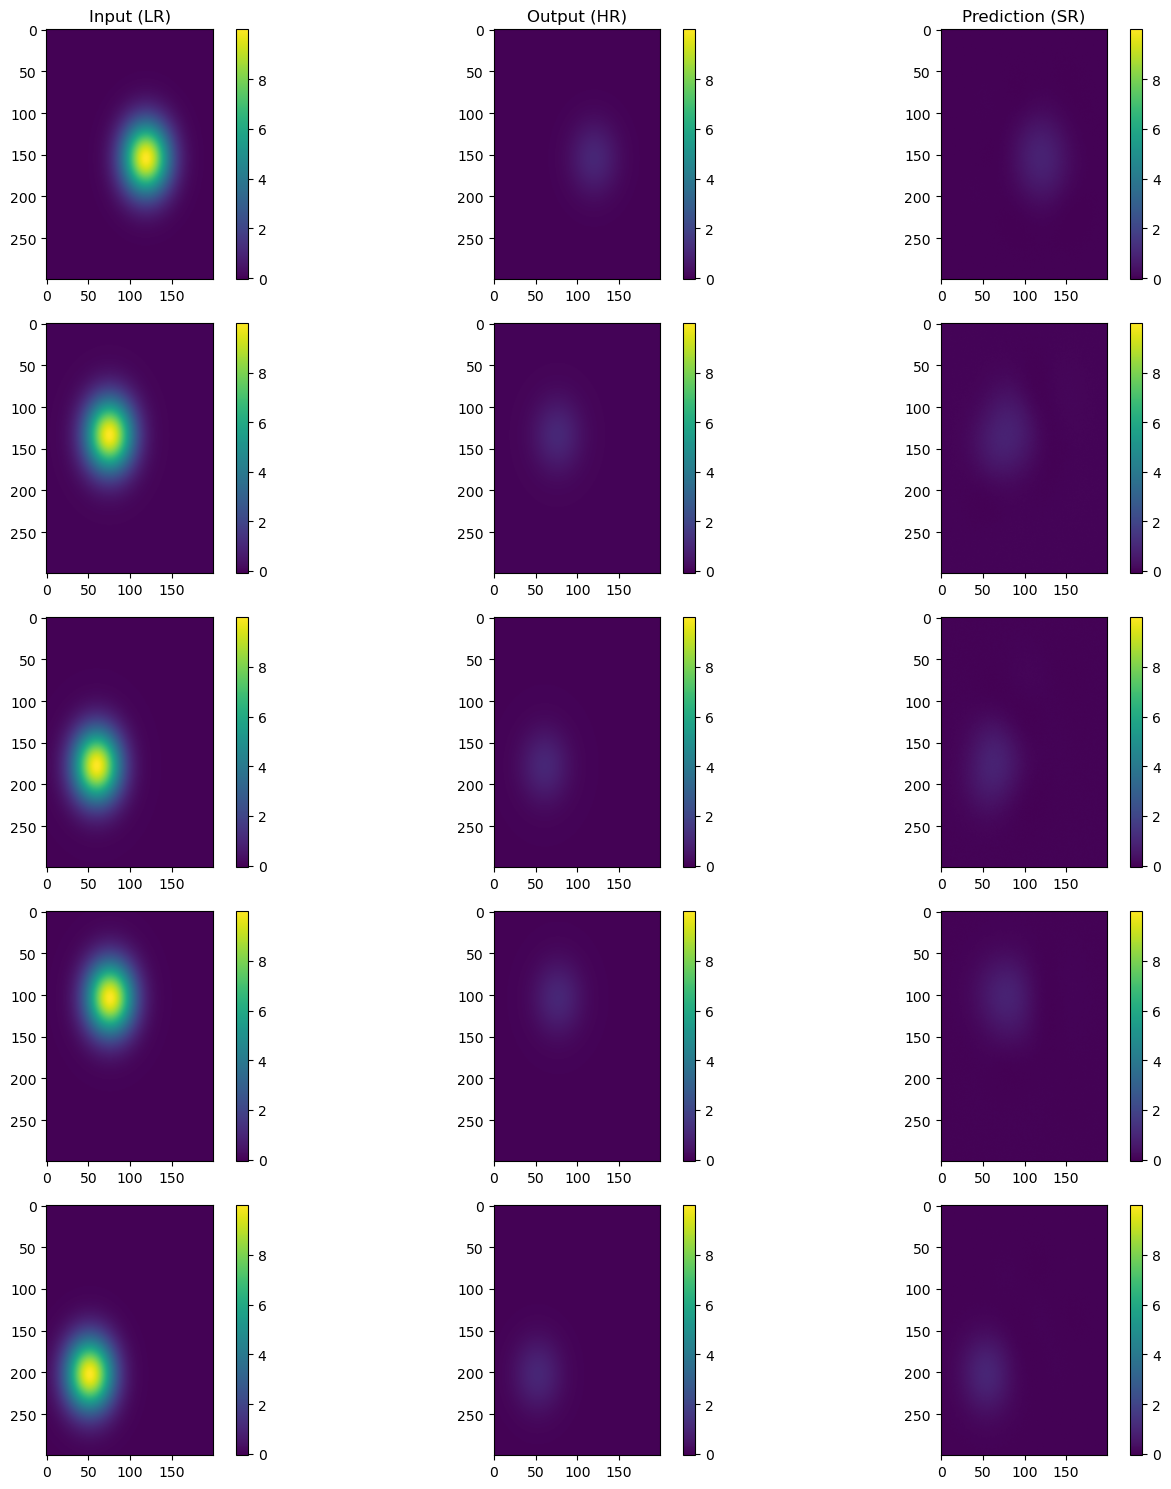

In [30]:
plot_predictions_vs_targets(LR_test, HR_test, sr_pred, num_samples=5, cmap='viridis')

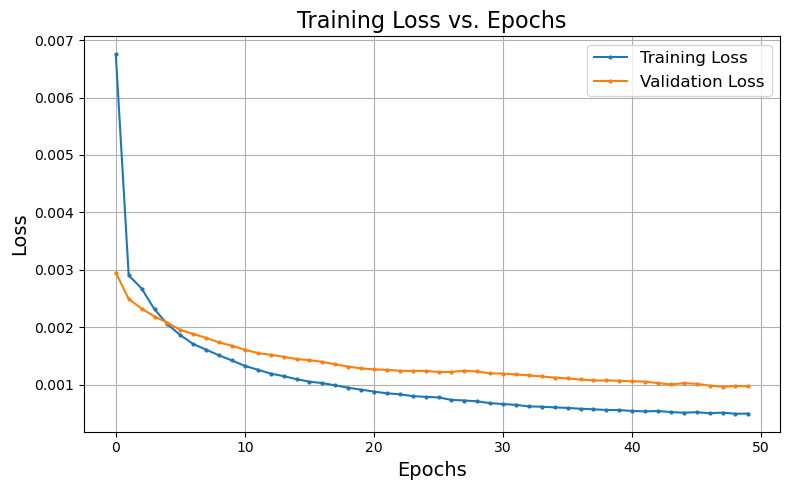

In [31]:
plot_train_val_losses(train_losses, val_losses)

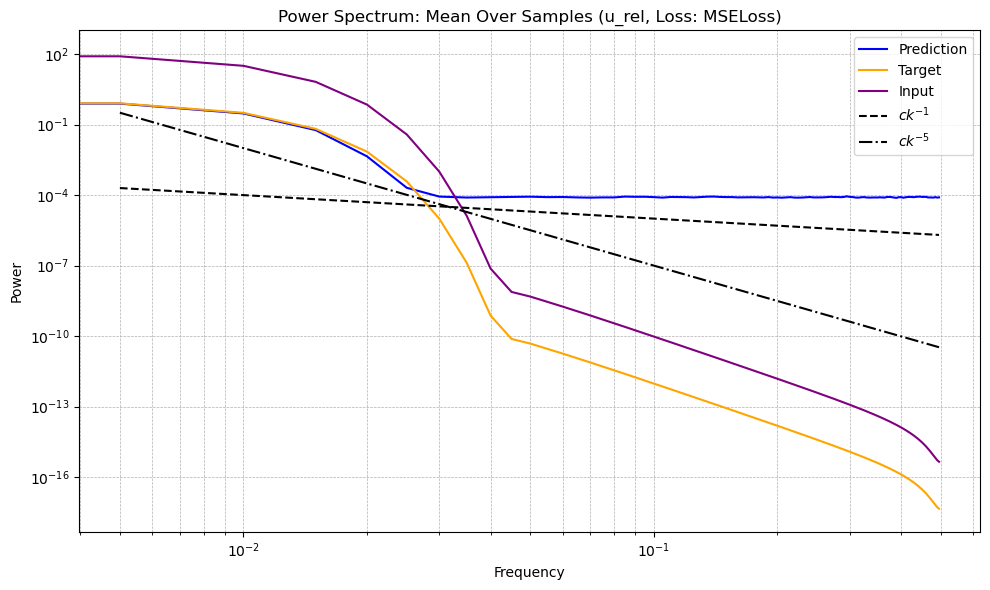

In [32]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6),
    c1=10**-6, c5=10**-12, show_slopes=True)

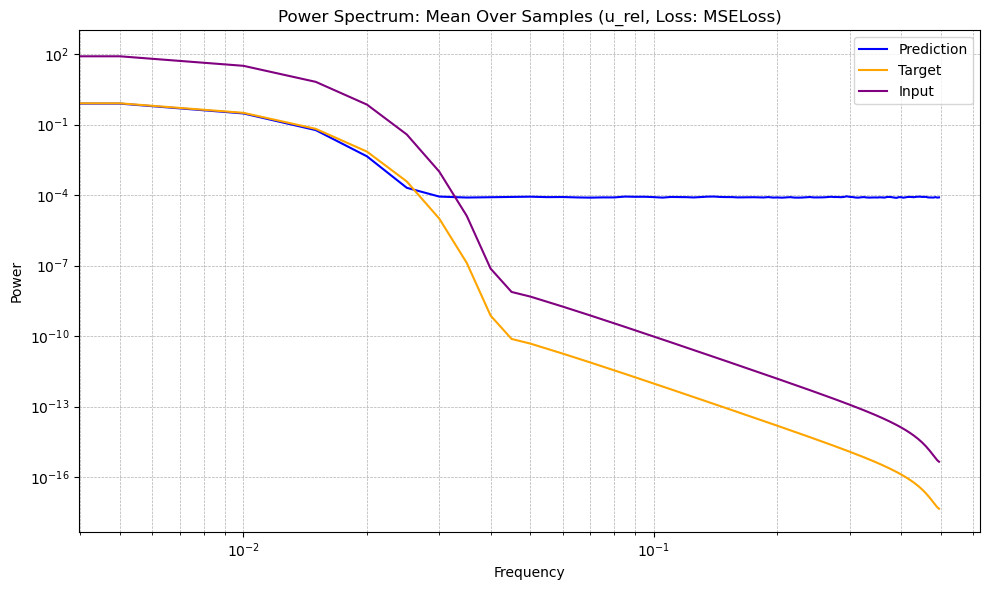

In [33]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6))

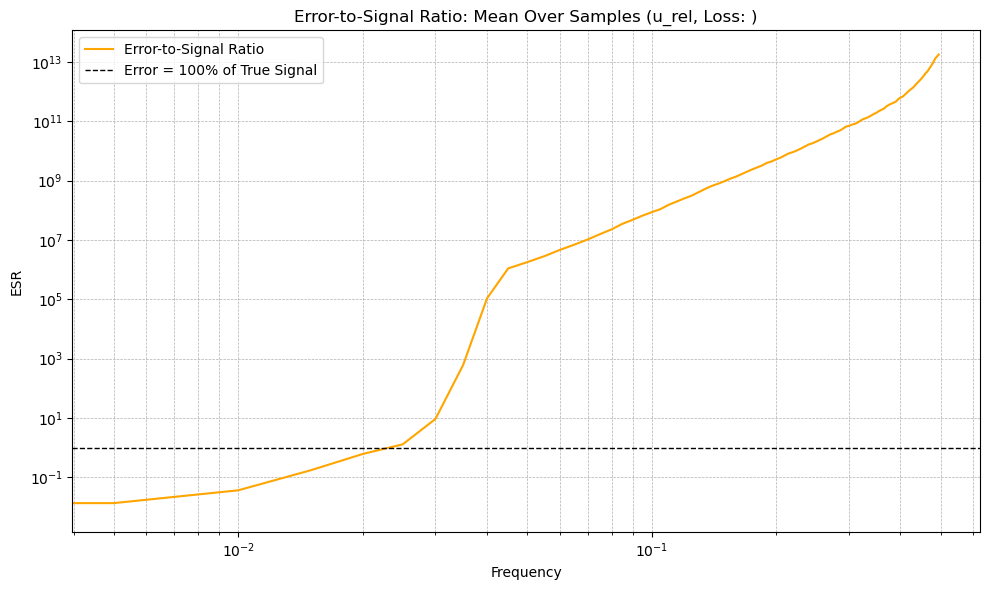

In [34]:
plot_mean_esr(sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="", alpha_label="", figsize=(10, 6))

In [35]:
mse(HR_test, sr_pred)

0.0011027325849785974

In [36]:
pearson_corr(HR_test, sr_pred)

0.9795968154898528

In [37]:
r2_score(HR_test, sr_pred)

0.9595926941757901

# Case 3: No Normalization

In [38]:
train_loader, val_loader, test_loader, HR_test, LR_test = prepare_dataloaders(ds_HR_blob, ds_LR_blob, var='u_relative', batch_size=32)

Training set size: 70
Validation set size: 15
Testing set size: 15


In [39]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_base_dummy.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 15341024
Epoch 1, Train Loss: 2.613e-03, Val Loss: 2.361e-03, Epoch Time: 17.82s
Model saved at epoch 1
Epoch 2, Train Loss: 2.274e-03, Val Loss: 2.011e-03, Epoch Time: 21.80s
Model saved at epoch 2
Epoch 3, Train Loss: 1.923e-03, Val Loss: 1.654e-03, Epoch Time: 26.77s
Model saved at epoch 3
Epoch 4, Train Loss: 1.568e-03, Val Loss: 1.303e-03, Epoch Time: 28.90s
Model saved at epoch 4
Epoch 5, Train Loss: 1.224e-03, Val Loss: 9.779e-04, Epoch Time: 21.75s
Model saved at epoch 5
Epoch 6, Train Loss: 9.089e-04, Val Loss: 7.004e-04, Epoch Time: 24.48s
Model saved at epoch 6
Epoch 7, Train Loss: 6.470e-04, Val Loss: 4.922e-04, Epoch Time: 25.11s
Model saved at epoch 7
Epoch 8, Train Loss: 4.564e-04, Val Loss: 3.638e-04, Epoch Time: 20.39s
Model saved at epoch 8
Epoch 9, Train Loss: 3.449e-04, Val Loss: 3.076e-04, Epoch Time: 22.45s
Model saved at epoch 9
Epoch 10, Train Loss: 3.000e-04, Val Loss: 2.949e-04, Epoch Time: 13.81s
Model saved at epoch 10
Epoch 11, Train L

In [40]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_base_dummy.pth')
sr_pred

Loaded model parameters from ./model_CNN_base_dummy.pth


<xarray.DataArray (time: 15, yt_ocean: 300, xt_ocean: 200)> Size: 4MB
array([[[-1.4522672e-04,  3.7937425e-04, -2.1642074e-04, ...,
         -5.4888194e-05, -2.6647002e-05, -2.3916364e-06],
        [ 3.2948796e-04, -5.0570816e-05,  3.6051311e-04, ...,
          9.0450922e-05, -1.1018664e-04,  1.4510565e-04],
        [-2.4375319e-04, -5.3638406e-04, -6.1487313e-04, ...,
         -2.3931637e-04, -3.1509902e-04, -6.4710155e-04],
        ...,
        [ 3.7588179e-05,  1.1380855e-04,  1.6788766e-04, ...,
          3.8466789e-04, -1.6527483e-05,  2.1645630e-04],
        [ 3.0595576e-05, -2.3981556e-07,  1.1792639e-04, ...,
         -4.3502077e-04, -4.7531910e-05,  2.2696517e-04],
        [-2.9566512e-04, -3.0632317e-04, -2.9475335e-04, ...,
         -5.9424713e-04,  1.5518814e-04, -6.2512700e-04]],

       [[-1.4522672e-04,  3.7937425e-04, -2.1642074e-04, ...,
         -5.4888194e-05, -2.6647002e-05, -2.3916364e-06],
        [ 3.2948796e-04, -5.0570816e-05,  3.6051311e-04, ...,
          9.0450922e-05, -1.1018664e-04,  1.4510565e-04],
        [-2.4375319e-04, -5.3638406e-04, -6.1487313e-04, ...,
         -2.3931637e-04, -3.1509902e-04, -6.4710155e-04],
...
          3.8466789e-04, -1.6527483e-05,  2.1645630e-04],
        [ 3.0595576e-05, -2.3981556e-07,  1.1792639e-04, ...,
         -4.3502077e-04, -4.7531910e-05,  2.2696517e-04],
        [-2.9566512e-04, -3.0632317e-04, -2.9475335e-04, ...,
         -5.9424713e-04,  1.5518814e-04, -6.2512700e-04]],

       [[-1.4522672e-04,  3.7937425e-04, -2.1642074e-04, ...,
         -5.4888194e-05, -2.6647002e-05, -2.3916364e-06],
        [ 3.2948796e-04, -5.0570816e-05,  3.6051311e-04, ...,
          9.0450922e-05, -1.1018664e-04,  1.4510565e-04],
        [-2.4375319e-04, -5.3638406e-04, -6.1487313e-04, ...,
         -2.3931637e-04, -3.1509902e-04, -6.4710155e-04],
        ...,
        [ 3.7588179e-05,  1.1380855e-04,  1.6788766e-04, ...,
          3.8466789e-04, -1.6527483e-05,  2.1645630e-04],
        [ 3.0595576e-05, -2.3981556e-07,  1.1792639e-04, ...,
         -4.3502077e-04, -4.7531910e-05,  2.2696517e-04],
        [-2.9566512e-04, -3.0632317e-04, -2.9475335e-04, ...,
         -5.9424713e-04,  1.5518814e-04, -6.2512700e-04]]],
      shape=(15, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 120B 0182-08-04 12:00:00 ... 0181-06-10 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

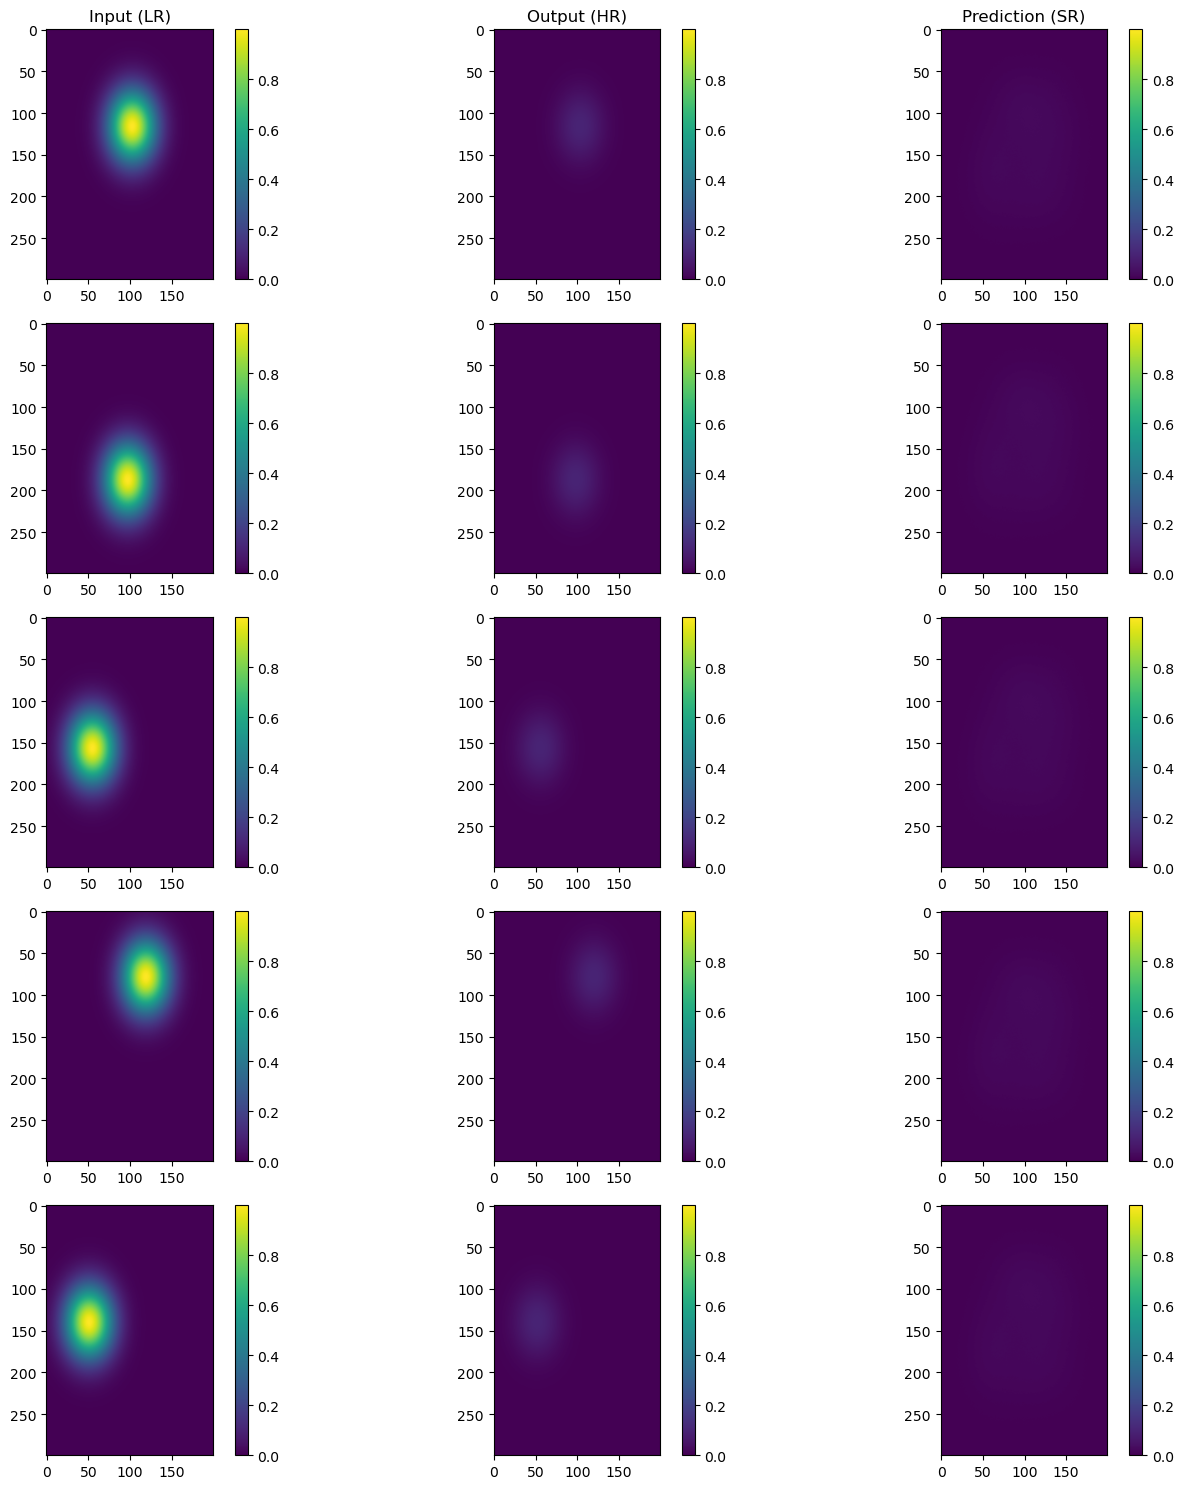

In [41]:
plot_predictions_vs_targets(LR_test, HR_test, sr_pred, num_samples=5, cmap='viridis')

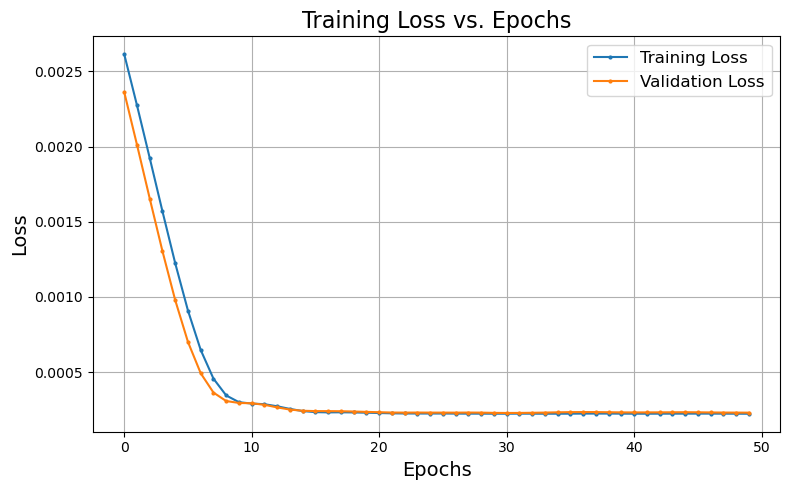

In [42]:
plot_train_val_losses(train_losses, val_losses)

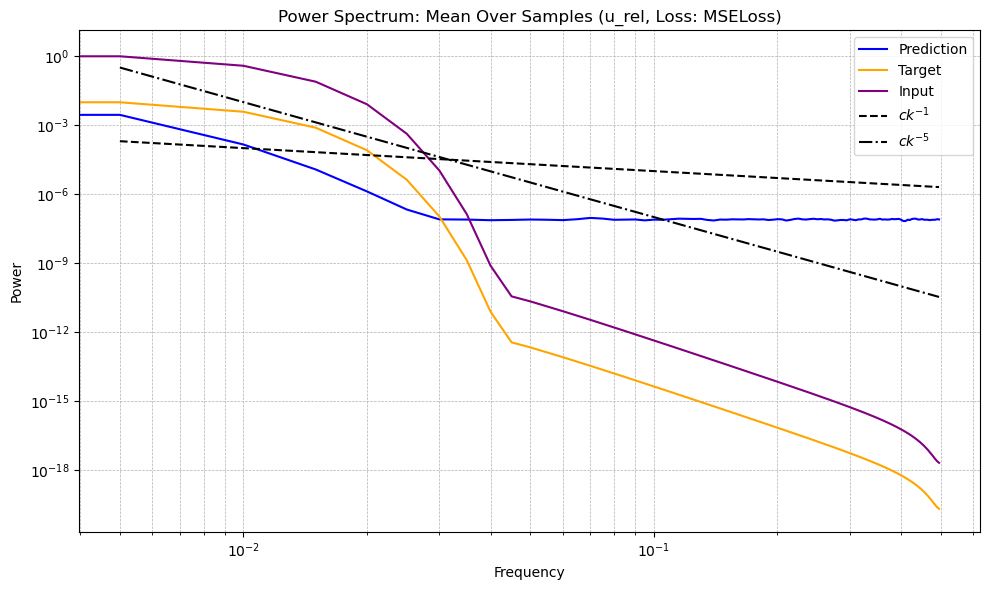

In [43]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6),
    c1=10**-6, c5=10**-12, show_slopes=True)

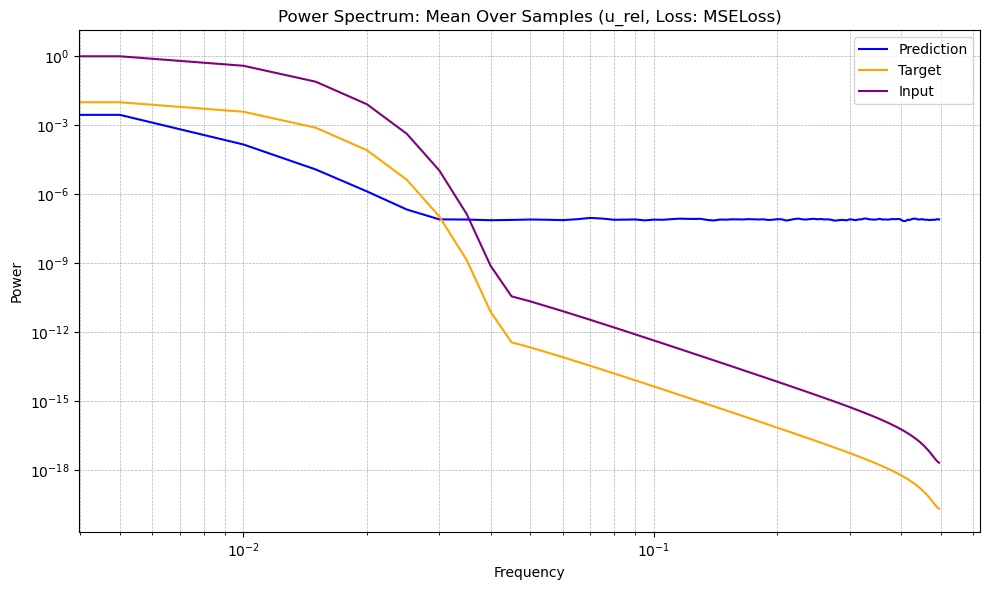

In [44]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6))

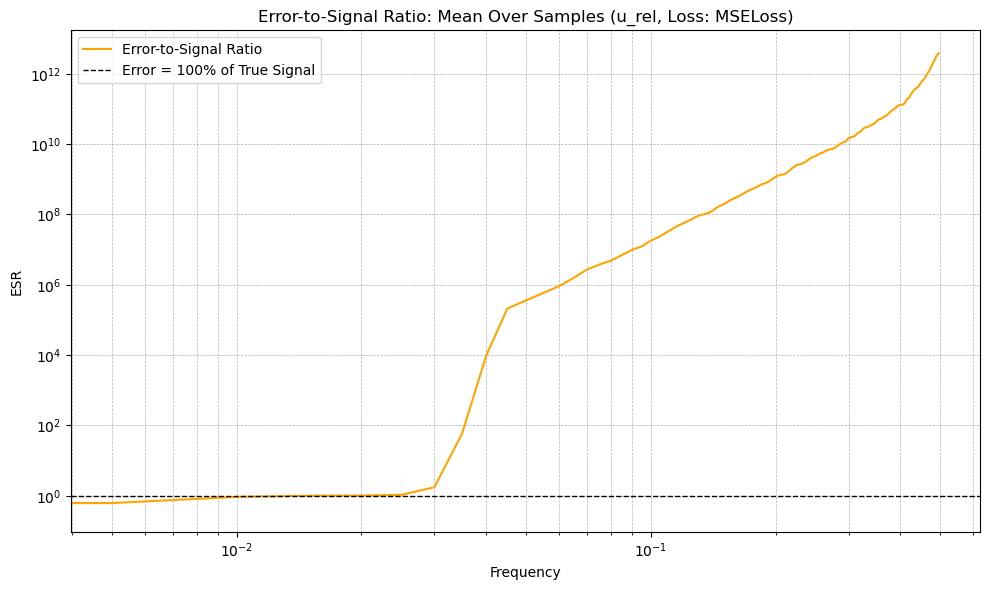

In [45]:
plot_mean_esr(sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="MSELoss", alpha_label="", figsize=(10, 6))

In [46]:
mse(HR_test, sr_pred)

0.00020456427969457733

In [47]:
pearson_corr(HR_test, sr_pred)

0.5063870380751726

In [48]:
r2_score(HR_test, sr_pred)

0.25016767564219755

# Case 4: No Normalization, CombinedLoss (alpha = 1)

In [ ]:
train_loader, val_loader, test_loader, HR_test, LR_test = prepare_dataloaders(ds_HR_blob, ds_LR_blob, var='u_relative', batch_size=32)

Training set size: 70
Validation set size: 15
Testing set size: 15


In [ ]:
criterion = CombinedLoss(alpha=1) # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_alpha1_dummy.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 15341024
Epoch 1, Train Loss: 3.486e-04, Val Loss: 3.606e-04, Epoch Time: 26.16s
Model saved at epoch 1
Epoch 2, Train Loss: 3.478e-04, Val Loss: 2.821e-04, Epoch Time: 46.68s
Model saved at epoch 2
Epoch 3, Train Loss: 2.842e-04, Val Loss: 3.004e-04, Epoch Time: 40.60s
Model saved at epoch 3
Epoch 4, Train Loss: 2.775e-04, Val Loss: 2.893e-04, Epoch Time: 53.46s
Model saved at epoch 4
Epoch 5, Train Loss: 2.745e-04, Val Loss: 2.810e-04, Epoch Time: 27.08s
Model saved at epoch 5
Epoch 6, Train Loss: 2.621e-04, Val Loss: 2.845e-04, Epoch Time: 35.40s
Model saved at epoch 6
Epoch 7, Train Loss: 2.623e-04, Val Loss: 2.813e-04, Epoch Time: 39.46s
Model saved at epoch 7
Epoch 8, Train Loss: 2.573e-04, Val Loss: 2.831e-04, Epoch Time: 37.00s
Model saved at epoch 8
Epoch 9, Train Loss: 2.566e-04, Val Loss: 2.818e-04, Epoch Time: 31.72s
Model saved at epoch 9
Epoch 10, Train Loss: 2.547e-04, Val Loss: 2.815e-04, Epoch Time: 34.31s
Model saved at epoch 10
Epoch 11, Train L

In [ ]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_alpha1_dummy.pth')
sr_pred

Loaded model parameters from ./model_CNN_alpha1_dummy.pth


<xarray.DataArray (time: 15, yt_ocean: 300, xt_ocean: 200)> Size: 4MB
array([[[-1.65067613e-05,  4.63780016e-05,  2.30073929e-05, ...,
         -1.04433857e-05, -6.07594848e-05,  4.24422324e-05],
        [ 7.28759915e-05, -7.08429143e-05,  3.20672989e-05, ...,
          8.07883407e-06,  2.76714563e-05, -3.52985226e-05],
        [ 4.51095402e-05,  1.72602013e-05,  3.43574211e-05, ...,
         -1.24275684e-05, -8.17049295e-06,  1.14496797e-05],
        ...,
        [ 1.26659870e-06, -6.68349676e-05,  2.95788050e-06, ...,
         -2.16094777e-05, -2.36399937e-05, -3.55861266e-06],
        [ 9.43720806e-05, -1.10315159e-05,  3.42126004e-05, ...,
          9.28714871e-06, -3.09464522e-05,  5.19230962e-05],
        [-9.68025997e-05,  4.34890389e-05, -1.25952065e-05, ...,
         -4.52734530e-05,  3.99624696e-05, -4.69684601e-05]],

       [[-1.65067613e-05,  4.63780016e-05,  2.30073929e-05, ...,
         -1.04433857e-05, -6.07594848e-05,  4.24422324e-05],
        [ 7.28759915e-05, -7.08429143e-05,  3.20672989e-05, ...,
          8.07883407e-06,  2.76714563e-05, -3.52985226e-05],
        [ 4.51095402e-05,  1.72602013e-05,  3.43574211e-05, ...,
         -1.24275684e-05, -8.17049295e-06,  1.14496797e-05],
...
         -2.16094777e-05, -2.36399937e-05, -3.55861266e-06],
        [ 9.43720806e-05, -1.10315159e-05,  3.42126004e-05, ...,
          9.28714871e-06, -3.09464522e-05,  5.19230962e-05],
        [-9.68025997e-05,  4.34890389e-05, -1.25952065e-05, ...,
         -4.52734530e-05,  3.99624696e-05, -4.69684601e-05]],

       [[-1.65067613e-05,  4.63780016e-05,  2.30073929e-05, ...,
         -1.04433857e-05, -6.07594848e-05,  4.24422324e-05],
        [ 7.28759915e-05, -7.08429143e-05,  3.20672989e-05, ...,
          8.07883407e-06,  2.76714563e-05, -3.52985226e-05],
        [ 4.51095402e-05,  1.72602013e-05,  3.43574211e-05, ...,
         -1.24275684e-05, -8.17049295e-06,  1.14496797e-05],
        ...,
        [ 1.26659870e-06, -6.68349676e-05,  2.95788050e-06, ...,
         -2.16094777e-05, -2.36399937e-05, -3.55861266e-06],
        [ 9.43720806e-05, -1.10315159e-05,  3.42126004e-05, ...,
          9.28714871e-06, -3.09464522e-05,  5.19230962e-05],
        [-9.68025997e-05,  4.34890389e-05, -1.25952065e-05, ...,
         -4.52734530e-05,  3.99624696e-05, -4.69684601e-05]]],
      shape=(15, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 120B 0182-04-26 12:00:00 ... 0183-07-10 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

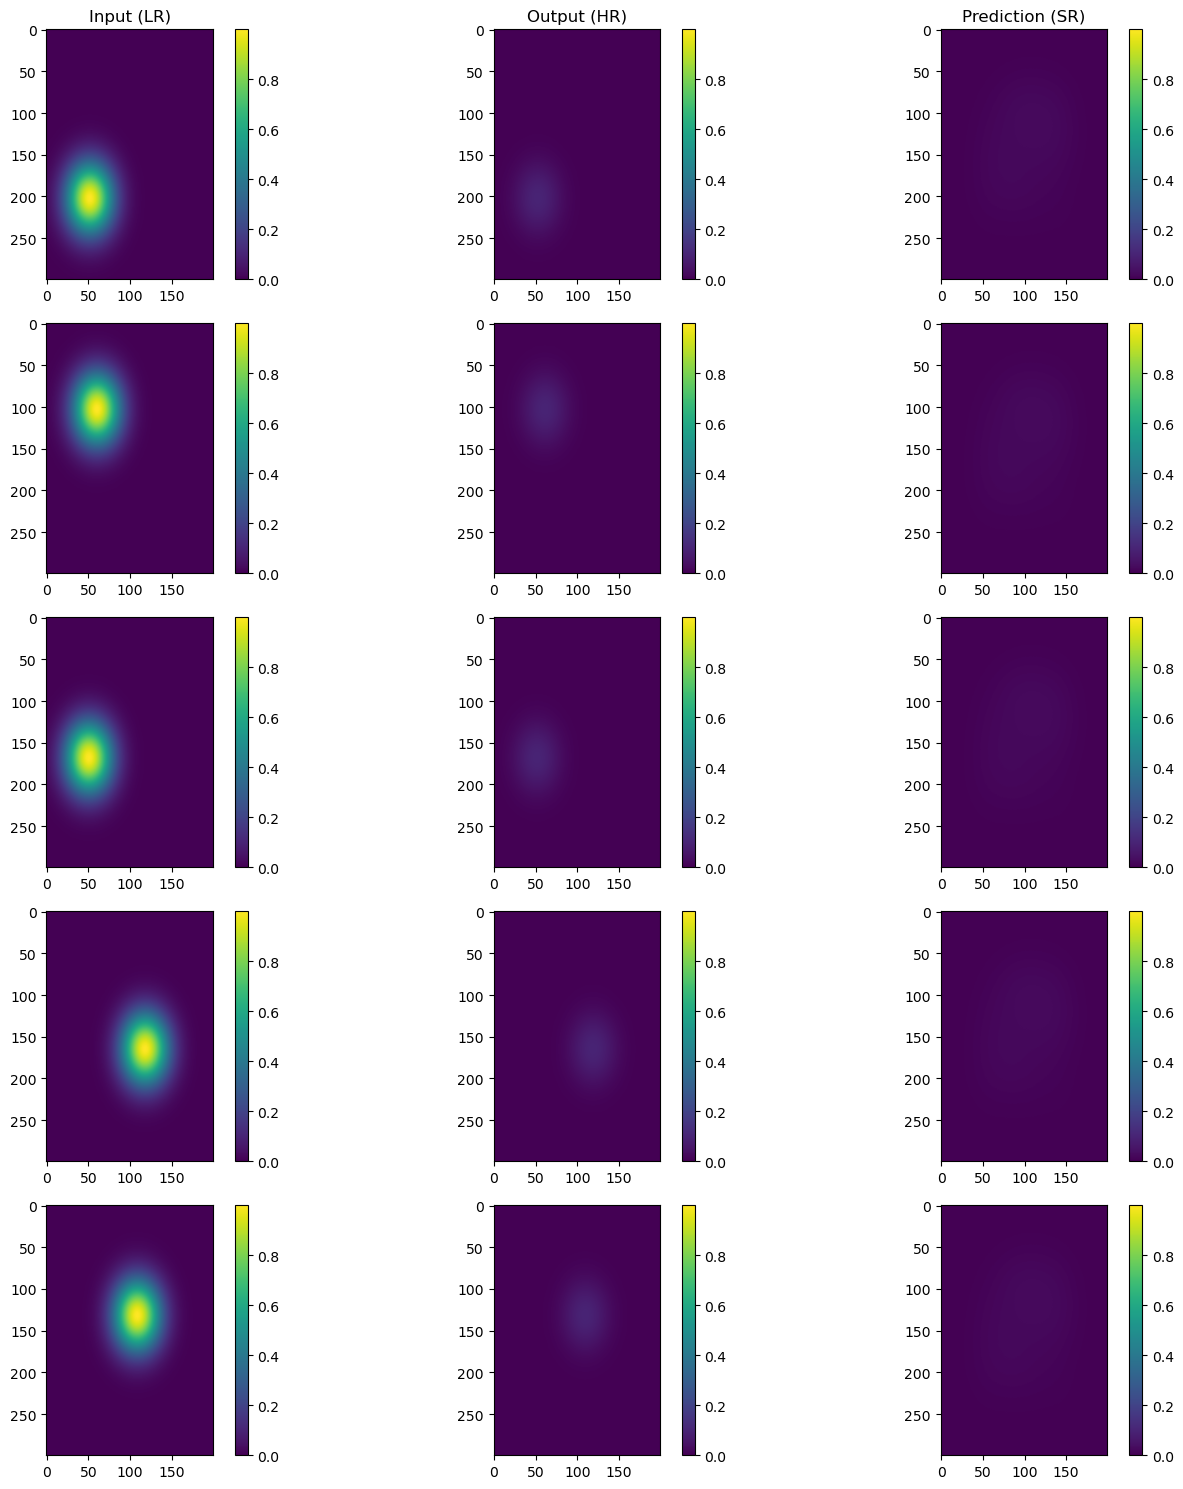

In [ ]:
plot_predictions_vs_targets(LR_test, HR_test, sr_pred, num_samples=5, cmap='viridis')

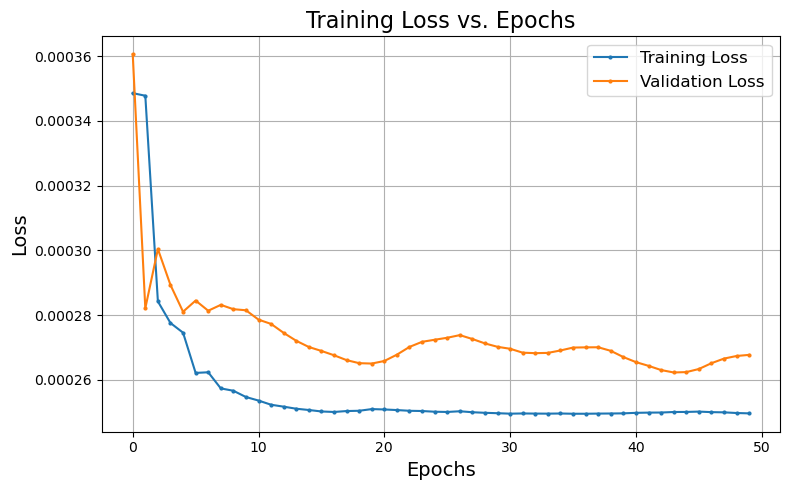

In [ ]:
plot_train_val_losses(train_losses, val_losses)

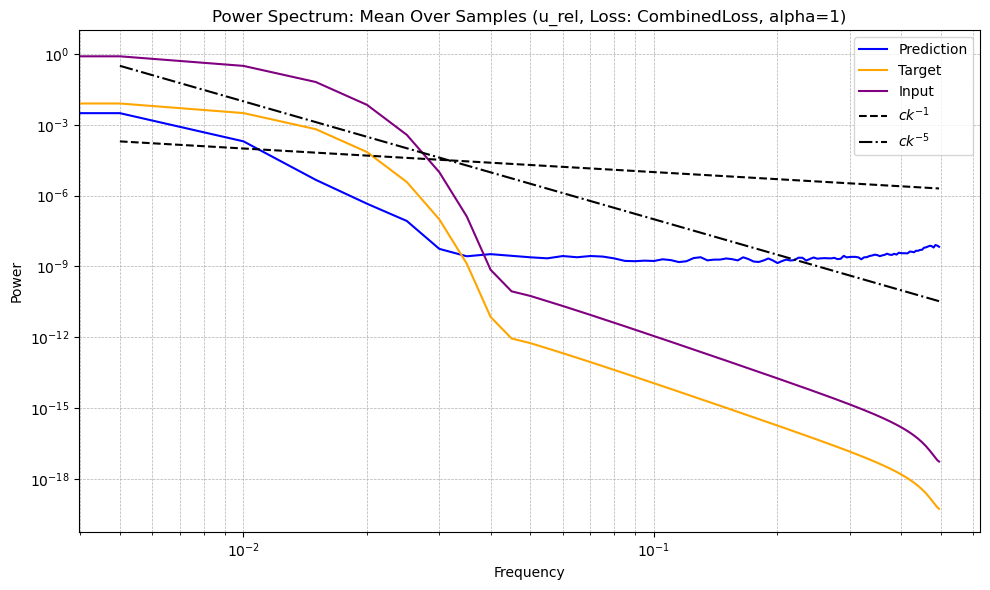

In [ ]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="CombinedLoss", alpha_label="alpha=1", figsize=(10, 6),
    c1=10**-6, c5=10**-12, show_slopes=True)

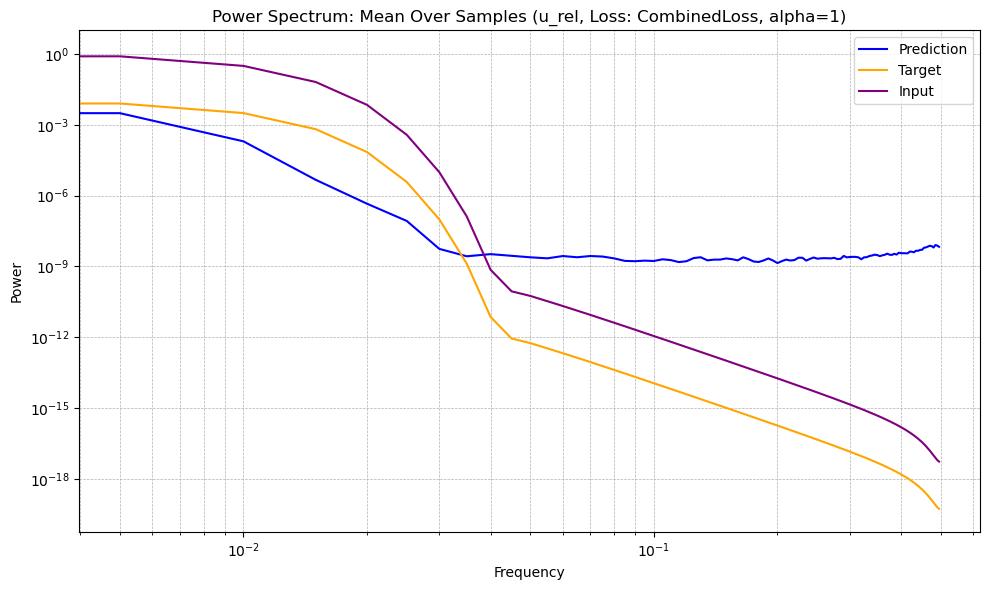

In [ ]:
plot_mean_power_spectrum(
    sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="CombinedLoss", alpha_label="alpha=1", figsize=(10, 6))

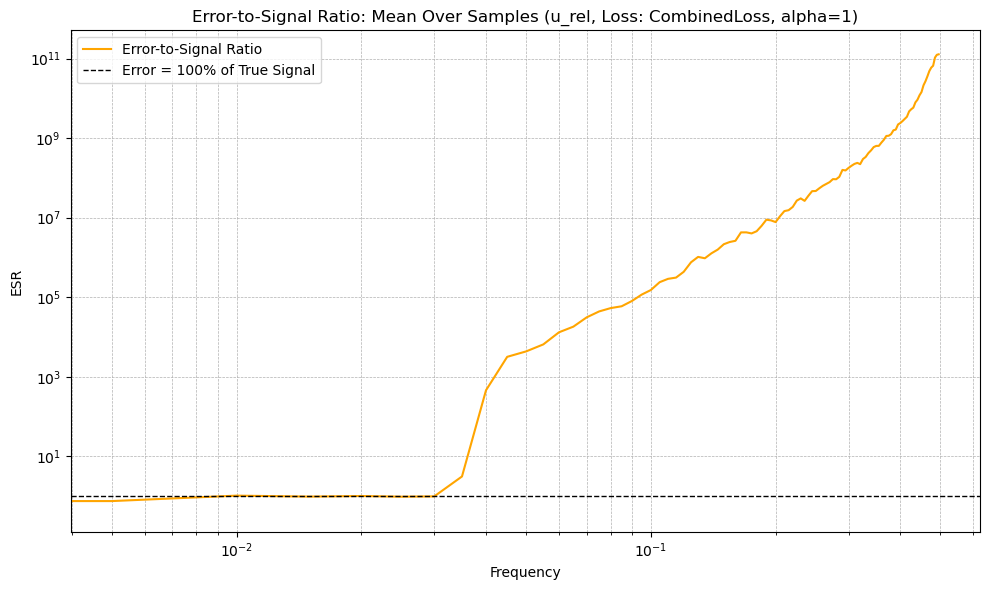

In [ ]:
plot_mean_esr(sr_pred, HR_test, LR_test, var_name="u_rel", loss_name="CombinedLoss", alpha_label="alpha=1", figsize=(10, 6))